Данная работа посвящена изучению пропускной способности каналов с мягкими решениями $C_S(M, \mu_S^2)$

Очевидно $C_S(M, \mu_S^2) = H(C) - H(C|Y) \le H(C) \le log_2 M$

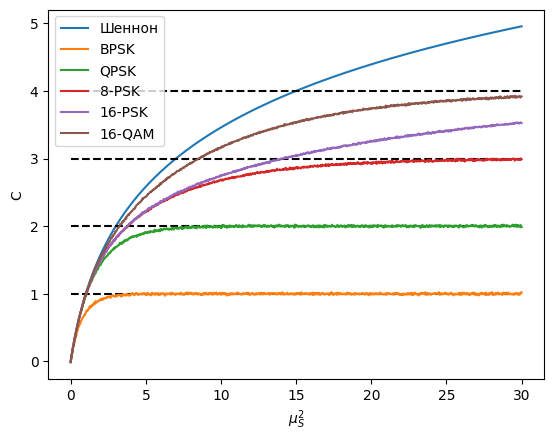

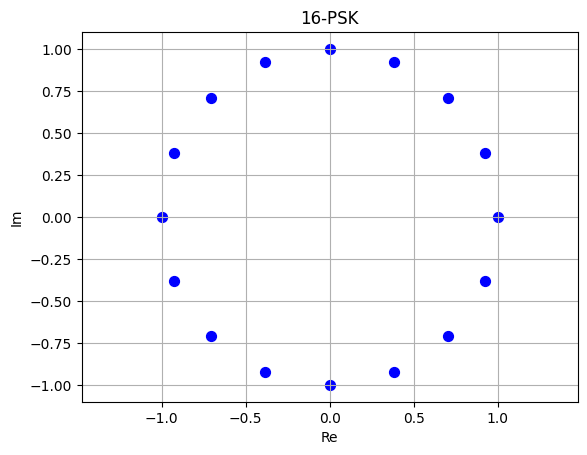

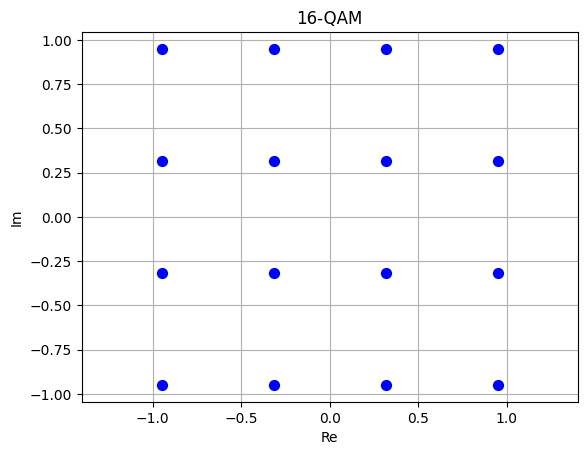

In [66]:
import matplotlib.pyplot as plt
from math import sqrt
import numpy as np

def max_C(mu_s2 : float | np.ndarray):
    return np.log2(1 + mu_s2)

# Базовый класс, задающий распределение непрерывной 
# случайной величины в комплексной плоскости 
class Distribution:
    # возвращает sample(массив выборок) размера size
    def __call__(self, size = 1):
        return np.zeros(size)

# Нормальное распределение Z = X + jY, X,Y ~ N(0, sigma^2) => D[Z] = 2sigma^2
class ComplexNormalDistribution(Distribution):
    def __init__(self, sigma = 1.0):
        self.sigma = sigma

    def __call__(self, size = 1):
        X = np.random.normal(0, self.sigma, size)
        Y = np.random.normal(0, self.sigma, size)
        return X + 1j*Y

class Constellation(Distribution):
    def __init__(self, symbols : list[complex]):
        self.symbols = symbols
        self.M = len(symbols)

    def __call__(self, size = 1):
        return np.random.choice(self.symbols, size)

# Численно находит плотности распределения в заданных точках
# C - созвездие, для которого ищем плотность
# 2sigma^2 - дисперсия шума в AWGN канале
def get_density(sample : np.ndarray, C : Constellation, sigma : float):
    N = len(sample)
    y = sample[:, np.newaxis]
    symbols = np.array(C.symbols)[np.newaxis, :]
    disp = 2*sigma*sigma
    distances2 = np.abs(y - symbols)**2
    rho = np.sum(np.exp(-distances2 / disp), axis=1) / (C.M * np.pi * disp)
    return rho

# находит дифференциальную энтропию как -E[log(rho(x))] методом Монте-Карло,
# учитывая точную плотность распределения выходного сигнала
def h(sample : np.ndarray, C : Constellation, sigma : float):
    return -float(np.sum(np.log2(get_density(sample, C, sigma)))) / len(sample)

# Y = C + N, N ~ ComplexNormalDistribution
class AWGNChannel:
    def __init__(self, sigma : float):
        self.N = ComplexNormalDistribution(sigma)
        self.sigma = sigma

    # вычисление взаимной информации I(C,Y)
    def get_I(self, C : Constellation):
        return h(self.get_Y(C, 25000), C, self.sigma) - np.log2(2*np.pi*np.e*self.sigma*self.sigma)

    # возвращает sample выходного распределения размера size
    def get_Y(self, C : Distribution, size = 1):
        return C(size) + self.N(size)

channel = AWGNChannel(1/sqrt(2)) # mu_s^2 = E[C^2]

def BPSK_C(mu_s2 : float):
    mu_s = sqrt(mu_s2)
    BPSK = Constellation([-mu_s, mu_s])
    return channel.get_I(BPSK)

def QPSK_C(mu_s2 : float):
    mu_s = sqrt(mu_s2)
    BPSK = Constellation([-mu_s, mu_s, -1j*mu_s, 1j*mu_s])
    return channel.get_I(BPSK)

def PSK8_C(mu_s2 : float):
    mu_s = sqrt(mu_s2)
    PSK8 = Constellation([np.exp(1j*2*np.pi*k/8)*mu_s for k in range(8)])
    return channel.get_I(PSK8)

def PSK16_C(mu_s2 : float):
    mu_s = sqrt(mu_s2)
    PSK16 = Constellation([np.exp(1j*2*np.pi*k/16)*mu_s for k in range(16)])
    return channel.get_I(PSK16)

def QAM16_C(mu_s2: float):
    mu_s = sqrt(mu_s2)
    levels = np.array([-3, -1, 1, 3], dtype=float)
    levels *= mu_s / sqrt(10)
    symbols = [i + 1j*q for i in levels for q in levels]
    QAM16 = Constellation(symbols)
    return channel.get_I(QAM16)

def xarg(func, args):
    return [func(arg) for arg in args]

mu2 = np.linspace(0, 30, 1000)
plt.plot(mu2, max_C(mu2), label="Шеннон")
plt.hlines([1, 2, 3, 4], 0, 30, "#000000", "dashed") # type: ignore
plt.plot(mu2, xarg(BPSK_C, mu2), label="BPSK")
plt.plot(mu2, xarg(QPSK_C, mu2), label="QPSK")
plt.plot(mu2, xarg(PSK8_C, mu2), label="8-PSK")
plt.plot(mu2, xarg(PSK16_C, mu2), label="16-PSK")
plt.plot(mu2, xarg(QAM16_C, mu2), label="16-QAM")
plt.xlabel(r"$\mu_S^2$")
plt.ylabel("C")
plt.legend()
plt.show()

def draw_constellation(C : Constellation, name : str):
    symbols = np.array(C.symbols)
    plt.scatter(symbols.real, symbols.imag, color="blue", s=50)
    plt.xlabel("Re")
    plt.ylabel("Im")
    plt.title(name)
    plt.grid(True)
    plt.axis("equal")
    plt.show()

def get_M_PSK(M : int):
    return Constellation([np.exp(1j*2*np.pi*k/M) for k in range(M)])

def get_16_QAM():
    levels = np.array([-3, -1, 1, 3], dtype=float)
    symbols = [(i + 1j*q) / sqrt(10) for i in levels for q in levels]
    return Constellation(symbols)

draw_constellation(get_M_PSK(16), "16-PSK")
draw_constellation(get_16_QAM(), "16-QAM")

Видно, что верхняя оценка $log_2 M$ достигается. Причём 16-QAM делает это быстрее, что легко объяснить тем, что точки расположенные на квадратной решётки имеют большее минимальное расстояние.

Теперь посмотрим на энергию, необходимую для достижения определённой пропускной способности.

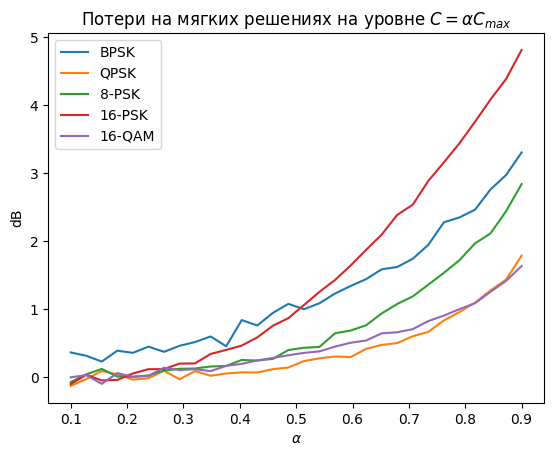

In [87]:
from scipy.optimize import root_scalar

# минимальное значение, получаемое из границы Шеннона для AWGN
def get_min_mu_s2(C : float):
    return 2**C - 1

def get_arg(func, value : float):
    def diff(mu_s2):
        return func(mu_s2) - value
    return root_scalar(diff, bracket=[0.001, 100], method="bisect").root

def get_dB(func, C : float):
    return 10 * np.log10(get_arg(func, C) / get_min_mu_s2(C))

def show_losses(func, name : str, C_max : float):
    alpha = np.linspace(0.1, 0.9, 30)
    dB = [get_dB(func, a*C_max) for a in alpha]
    plt.plot(alpha, dB, label=name)

plt.title("Потери на мягких решениях на уровне $C = \\alpha C_{max}$")
show_losses(BPSK_C, "BPSK", 1)
show_losses(QPSK_C, "QPSK", 2)
show_losses(PSK8_C, "8-PSK", 3)
show_losses(PSK16_C, "16-PSK", 4)
show_losses(QAM16_C, "16-QAM", 4)
plt.xlabel("$\\alpha$")
plt.ylabel("dB")
plt.legend()
plt.show()

Как видно из графиков мы теряем до 1 дБ на уровне $C = \frac{C_{max}}{2}$ при переходе не мягкие решения.

Кроме того, 16-PSK при попытке достичь $C = 0.9$ приводит к тому, что мы тратим в ~3 раза больше энергии(5 дБ).

При BPSK два сигнала строго противоположны по фазе. Это оптимально для передачи 1 бита/символ. Но при скорости ~0.1 бит/символ такая жесткая ортогональность избыточна и энергетически неоптимальна.

BPSK меньше остальных напоминает нормальное распределение и из-за чего показывает себя хуже остальных при малых и средних $\alpha$.

Если его не учитывать, то на больших $\alpha$ получем, что увеличение M для M-PSK приводит к ухудшению энергетической эффективности.